In [1]:
import pandas as pd
from pandas import Series, DataFrame

import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist

/Users/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv("data.csv")
data.head(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
# Description of continious variables
data.iloc[:,2:].describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### One Hot Encoding

In [4]:
for column in ('Channel', 'Region'):
    data = data.join(
        pd.get_dummies(
            data[column], 
            prefix=column[:3], 
            drop_first=True
        )
    )
    data.drop([column], inplace=True, axis=1)
data.head(5)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cha_2,Reg_2,Reg_3
0,12669,9656,7561,214,2674,1338,1,0,1
1,7057,9810,9568,1762,3293,1776,1,0,1
2,6353,8808,7684,2405,3516,7844,1,0,1
3,13265,1196,4221,6404,507,1788,0,0,1
4,22615,5410,7198,3915,1777,5185,1,0,1


In [5]:
clustervar = data.copy()

# Standardize predictors to have mean=0 and sd=1
for column_name in clustervar.columns:
    clustervar[column_name]=preprocessing.scale(clustervar[column_name].astype('float64'))
clustervar.head(5)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cha_2,Reg_2,Reg_3
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339,1.448652,-0.345822,0.626422
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151,1.448652,-0.345822,0.626422
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293,1.448652,-0.345822,0.626422
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411,-0.690297,-0.345822,0.626422
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347,1.448652,-0.345822,0.626422


In [6]:
# Split data into train and test sets
clus_train, clus_test = train_test_split(clustervar, test_size=.3, random_state=123)

In [7]:
# K-means cluster analysis for 1-9 clusters                                                           
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(
        sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) / clus_train.shape[0]
    )

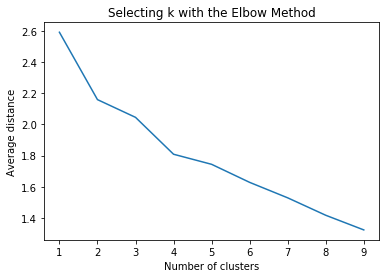

In [8]:
# Plot average distance from observations from the cluster centroid
# to use the Elbow Method to identify number of clusters to choose
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

### Analyzing model with 3 clusters

In [9]:
# Interpret 3 cluster solution
model3=KMeans(n_clusters=3)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)

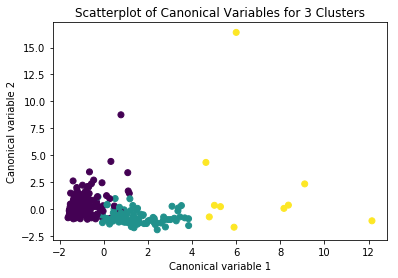

In [10]:
# plot Clusters
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

### Mergen cluster label with training data

In [11]:
# Create a unique identifier variable from the index for the 
# Cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)

newclus=DataFrame.from_dict(
    dict(zip(list(clus_train['index']), list(model3.labels_))), 
    orient='index'
)
newclus.columns = ['cluster']
newclus.reset_index(level=0, inplace=True)
newclus.head(5)

,index,cluster
0,138,0
1,201,1
2,378,0
3,283,0
4,171,1


In [12]:
# Merge the cluster assignment dataframe with the cluster
# Training variable dataframe by the index variable
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=5)

,index,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cha_2,Reg_2,Reg_3,cluster
0,138,0.121642,-0.208799,-0.307329,-0.601534,-0.552762,0.619876,-0.690297,-0.345822,0.626422,0
1,201,-0.594976,1.166949,1.765286,0.098382,2.383972,0.055426,1.448652,-0.345822,-1.596367,1
2,378,-0.694636,-0.339429,-0.637279,-0.575344,-0.590768,-0.145859,-0.690297,-0.345822,0.626422,0
3,283,1.089746,-0.296157,-0.625585,1.491202,-0.539114,-0.050009,-0.690297,-0.345822,0.626422,0
4,171,-0.934089,2.721890,1.249924,-0.499248,1.237079,1.677422,1.448652,-0.345822,0.626422,1


### Analysing results of clustering

In [13]:
# Cluster frequencies
merged_train.cluster.value_counts()

0    203
1     95
2     10
Name: cluster, dtype: int64

In [14]:
# Calculation of clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp.iloc[:,1:-3])

Clustering variable means by cluster
            Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
cluster                                                                      
0        0.095392 -0.337781 -0.417448  0.148127         -0.426257   -0.085395
1       -0.342896  0.435031  0.683093 -0.321616          0.711176    0.010393
2        0.650537  4.560363  3.592924  0.755754          3.506633    2.646892
